# INF265 - Week 6: CNNs, data augmentation and regularization
> Jakub Ryšavý


In [57]:
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import datetime

## 1. Data Generator 
Write a complete data generator for the *CIFAR10 dataset*. You can either download this dataset following this link: https://www.cs.toronto.
edu/~kriz/cifar.html, or you can directly import the dataset from torchvision, using the class ’torchvision.datasets.CIFAR10()’.

In [58]:
# Where to find the data or where to download the data if not found
data_path = 'data/'

# Instantiates a dataset for the training data and downloads the data if it is not present
cifar10_train = datasets.CIFAR10(
    data_path,       # location from which the data will be downloaded
    train=True,      # says whether we’re interested in the training set or the validation set
    download=True,   # says whether we allow PyTorch to download the data if not found in 'data_path'
    transform=transforms.ToTensor()
    )

print("Size of the training dataset", len(cifar10_train))

Files already downloaded and verified
Size of the training dataset 50000


In [59]:
# Same with validation dataset
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                               transform=transforms.ToTensor()) 
print("Size of the validation dataset", len(cifar10_val))

Files already downloaded and verified
Size of the validation dataset 10000


## 2. Sample dataset
Visualize a few samples for each label in the CIFAR10 dataset. Do you
expect the classification on this dataset to be as easy as the MNIST classification problem ? Why ?
> I would say, the task would be harder. There are also 10 classes; however, the differences are bigger (there are more types of dogs, cars, ...). Now we have to also deal with more colors.

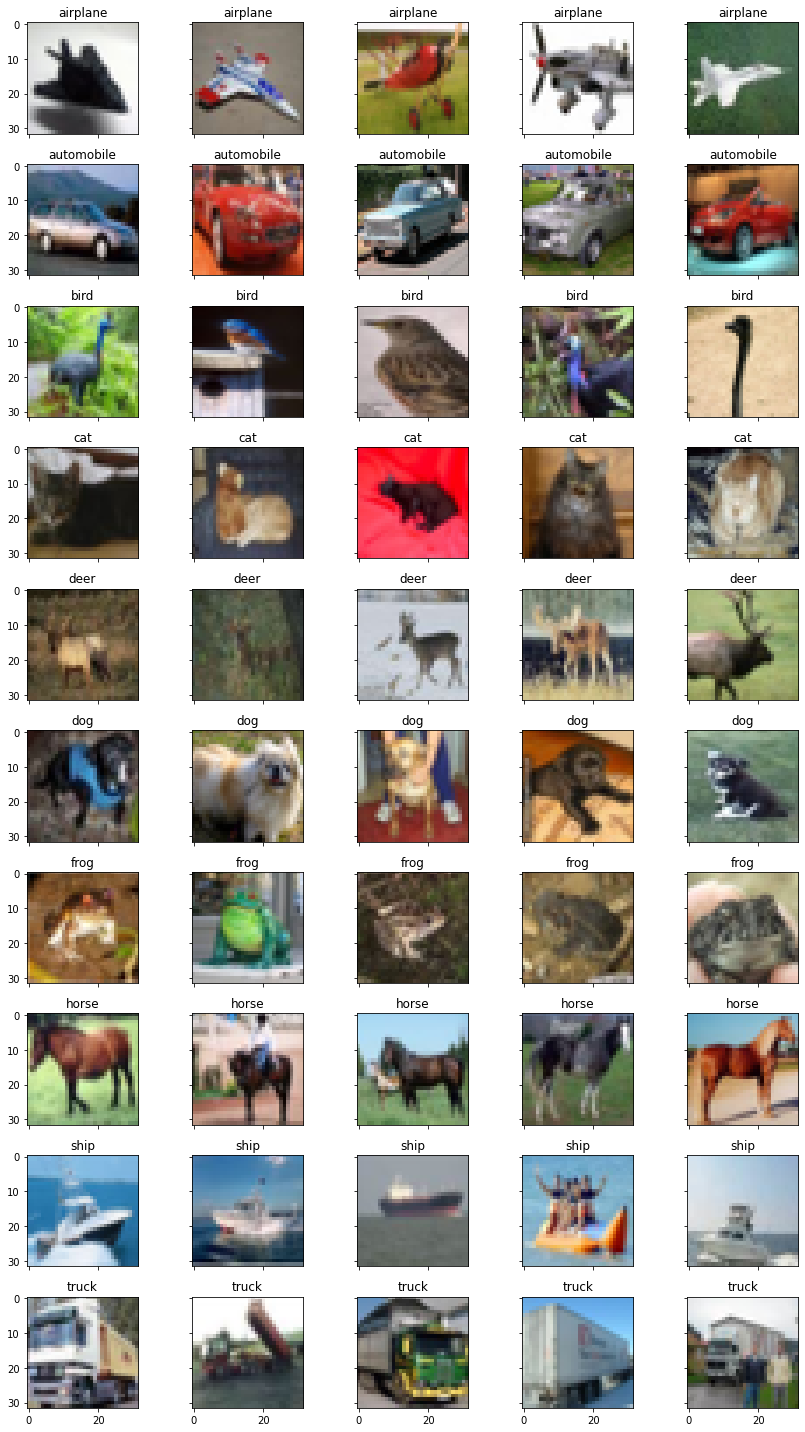

In [60]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = 10

# Create Figure and 10x5 gris of Axes objects
fig, axes = plt.subplots(nrows=num_classes, ncols=5, figsize=(12,20), sharey=True, sharex=True)
# Access Axes object with Numpy slicing then plot different distributions
for i in range(num_classes):
    class_name = class_names[i]
    imgs = []
    for j in range(5):
        img = next(img for img, label in cifar10_train if label == i and not any((img == e).all() for e in imgs))
        imgs.append(img)
        img = img.permute(1, 2, 0).numpy()
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
plt.tight_layout()
plt.show()

## 3. Optional: Subsample the CIFAR10 dataset
Optional: Subsample the CIFAR10 dataset such that the classification problem becomes restricted to a subset of the labels (keep enough labels such that the exercise remains interesting).

In [61]:
choosen_labels = [0, 2, 4, 6, 8]
num_classes = len(choosen_labels)

label_map = {0: 0, 2: 1, 4: 2, 6: 3, 8:4}

cifar5_train = [(img, label_map[label])
          for img, label in cifar10_train
          if label in choosen_labels]
print('Size of the training dataset: ', len(cifar5_train))

cifar5_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in choosen_labels]

print('Size of the validation dataset: ', len(cifar5_val))          

Size of the training dataset:  25000
Size of the validation dataset:  5000


## 4. CNN based on the LeNet5 architecture
Watch the following video: https://www.youtube.com/watch?v=bXJx7y51cl0&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=10, then implement in pytorch your own CNN based on the LeNet5 architecture introduced in LeCun’s seminal paper [1]. Your architecture can differ but should have a
similar structure.

In [62]:
class MyLeNet5(nn.Module):
    def __init__(self, dropout=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = dropout
        self.drop = nn.Dropout2d(p=0.5)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        if self.dropout:
            out = self.drop(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        if self.dropout:
            out = self.drop(out)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [63]:
model = MyLeNet5(dropout=True)
img, _ = cifar5_train[0]
output_tensor = model(img.unsqueeze(0))
print(output_tensor)

tensor([[ 0.1474,  0.0494,  0.0400,  0.0899, -0.0098]],
       grad_fn=<AddmmBackward>)


## 5. Train your CNN on the CIFAR10 dataset
Train your CNN on the CIFAR10 dataset and visualize the effect of overfitting.

In [64]:
def training_loop_on_gpu(n_epochs, optimizer, model, loss_fn, train_loader):
    losses = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
        losses.append(loss_train / len(train_loader))
    return losses

def validate_on_gpu(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [65]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

# train_loader = torch.utils.data.DataLoader(cifar2_train, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(cifar5_train, batch_size=64, shuffle=True)
model = MyLeNet5().to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

losses = training_loop_on_gpu(
    n_epochs = 101,
    # n_epochs = 1,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    )

Training on device cuda.
2021-02-14 17:54:52.252055 Epoch 1, Training loss 1.509664226066121
2021-02-14 17:55:00.604864 Epoch 10, Training loss 1.0635360470208366
2021-02-14 17:55:10.002783 Epoch 20, Training loss 0.8716535231341487
2021-02-14 17:55:19.307023 Epoch 30, Training loss 0.7640051738837795
2021-02-14 17:55:28.842807 Epoch 40, Training loss 0.6873391326278677
2021-02-14 17:55:38.442294 Epoch 50, Training loss 0.6314693625320864
2021-02-14 17:55:47.688072 Epoch 60, Training loss 0.5856425951204032
2021-02-14 17:55:57.242152 Epoch 70, Training loss 0.549423394834294
2021-02-14 17:56:06.376602 Epoch 80, Training loss 0.5154444694976368
2021-02-14 17:56:15.698365 Epoch 90, Training loss 0.48429027763778904
2021-02-14 17:56:25.199465 Epoch 100, Training loss 0.45835753406405144


In [66]:
train_loader = torch.utils.data.DataLoader(cifar5_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar5_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

all_acc_dict["overfitting"] = validate_on_gpu(model, train_loader, val_loader)

Accuracy train: 0.82
Accuracy val: 0.75


## 6. Try to reduce overfitting using at least one of the two following strategies:
- Add L2 regularization to the loss function of your CNN.
- Embed a data preprocessor performing random data augmentations inside your train generator using the classes available in ’torchvision.transforms’. Justify in your report your choice of transforms.


In [67]:
# Where to find the data or where to download the data if not found
data_path = 'data/'

# Instantiates a dataset for the training data and downloads the data if it is not present
cifar5_train = datasets.CIFAR10(
    data_path,       # location from which the data will be downloaded
    train=True,      # says whether we’re interested in the training set or the validation set
    download=True,   # says whether we allow PyTorch to download the data if not found in 'data_path'
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

print('Size of the training dataset: ', len(cifar5_train))

cifar5_val = datasets.CIFAR10(
    data_path, 
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
print('Size of the validation dataset: ', len(cifar5_val))

Files already downloaded and verified
Size of the training dataset:  50000
Files already downloaded and verified
Size of the validation dataset:  10000


In [68]:
choosen_labels = [0, 2, 4, 6, 8]
num_classes = len(choosen_labels)

label_map = {0: 0, 2: 1, 4: 2, 6: 3, 8:4}

cifar5_train = [(img, label_map[label])
          for img, label in cifar10_train
          if label in choosen_labels]
print('Size of the training dataset: ', len(cifar5_train))

cifar5_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in choosen_labels]

print('Size of the validation dataset: ', len(cifar5_val))

Size of the training dataset:  25000
Size of the validation dataset:  5000


In [69]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

train_loader = torch.utils.data.DataLoader(cifar5_train, batch_size=64, shuffle=True)
model2 = MyLeNet5(dropout=True).to(device=device) 
optimizer = optim.SGD(model2.parameters(), lr=1e-2)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

losses2 = training_loop_on_gpu(
    n_epochs = 101,
    # n_epochs = 1,
    optimizer = optimizer,
    model = model2,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Training on device cuda.
2021-02-14 17:56:35.156824 Epoch 1, Training loss 1.5741703906632445
2021-02-14 17:56:44.447156 Epoch 10, Training loss 1.1833224034370364
2021-02-14 17:56:54.891039 Epoch 20, Training loss 1.1054405144718298
2021-02-14 17:57:05.175516 Epoch 30, Training loss 1.0641058363268137
2021-02-14 17:57:15.394243 Epoch 40, Training loss 1.0240832027571891
2021-02-14 17:57:25.173089 Epoch 50, Training loss 1.003068728672574
2021-02-14 17:57:35.274836 Epoch 60, Training loss 0.9718742134321071
2021-02-14 17:57:45.543285 Epoch 70, Training loss 0.9581403871021612
2021-02-14 17:57:55.839857 Epoch 80, Training loss 0.9363441912414473
2021-02-14 17:58:05.948488 Epoch 90, Training loss 0.9184258478071988
2021-02-14 17:58:15.832531 Epoch 100, Training loss 0.9047247903121401


In [70]:
train_loader = torch.utils.data.DataLoader(cifar5_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar5_val, batch_size=64, shuffle=False)

all_acc_dict["better"] = validate_on_gpu(model2, train_loader, val_loader)

Accuracy train: 0.64
Accuracy val: 0.62


## 7. Conclusion
Were those strategies successful to cope with overfitting? Justify with visualization.
> I use for regularization 2 techniques:
- dropout,
- normalization.

> Both techniques help to reduce the overfitting.

In the following plot, we can see the values for train and validation loss and accuracy for both models.

We manage to reduce overfitting from 7% to (at least) 2% (of accuracy.

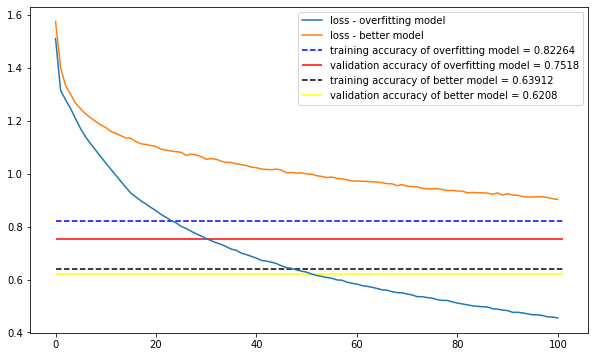

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='loss - overfitting model')
plt.plot(losses2, label='loss - better model')
plt.hlines(all_acc_dict['overfitting']['train'], 0, len(losses), 
           label='training accuracy of overfitting model = '+ str(all_acc_dict['overfitting']['train']), 
           linestyles='dashed', color='blue')
plt.hlines(all_acc_dict['overfitting']['val'], 0, len(losses), 
           label='validation accuracy of overfitting model = ' + str(all_acc_dict['overfitting']['val']), 
           color='red',)

plt.hlines(all_acc_dict['better']['train'], 0, len(losses), 
           label='training accuracy of better model = '+ str(all_acc_dict['better']['train']),
           linestyles='dashed')
plt.hlines(all_acc_dict['better']['val'], 0, len(losses), 
           label='validation accuracy of better model = ' + str(all_acc_dict['better']['val']), 
           color='yellow')
plt.legend()
plt.show()